In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from wordcloud import WordCloud 

In [2]:
df_train= pd.read_csv("train_E6oV3lV.csv")
df_train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
s=df_train.shape
s

(31962, 3)

In [5]:
df_test= pd.read_csv("test_tweets_anuFYb8.csv")
df_test.head()

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


In [8]:
n=  df_test.shape
n= n[0]
n

17197

In [9]:
df=  pd.concat([df_train, df_test])
df.shape

C:\Users\91758\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(49159, 3)

In [10]:
df['label'].value_counts()

0.0    29720
1.0     2242
Name: label, dtype: int64

In [11]:
#remove username starting with @
df['clean_tweet']= df['tweet'].replace(r'@\w+','',regex=True)

In [12]:
def decontracted(phrase):
    phrase = re.sub(r"n\'t", "n not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

#remove apostrphe from the word
df['clean_tweet']= [decontracted(i) for i in df['clean_tweet']]

In [13]:
df['clean_tweet'].head()

0      when a father is dysfunctional and is so sel...
1      thanks for #lyft credit i can not use cause ...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
Name: clean_tweet, dtype: object

In [14]:
#remove RT(retweet) 
df['clean_tweet'].replace('RT','',regex=True, inplace= True)

# Removing the links present in our clean text 
df['clean_tweet'].replace('((www\.[^\s]+)|(https?://[^\s]+))', '\0', inplace=True, regex=True)

# Removing special characters, numbers, punctuations as none of them would add any value while making sentiment analysis
df['clean_tweet'].replace('[^a-zAA-Z]+', ' ', inplace=True, regex=True)

#Removing the word 'hmm' and it's variants
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word == 'h(m)+' ]))

# Converting all the clean_text column into lower case
df['clean_tweet'] = df['clean_tweet'].str.lower()

In [15]:
#Code for removing slang words
d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food', 'u':'you'
    } ## Need a huge dictionary
words = "I luv myself"
words = words.split()
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join(d[word] if word in d else word for word in x.split()))

In [16]:
# TOKENIZATION
# Splitting each row of clean_text column into list of words
df['clean_tweet'] = df['clean_tweet'].str.split()

# Getting list of stopwords present in the nltk library
stop_words = stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')

# Removing the stopwords from every row of the column 'clean_text'
df['clean_tweet'] = df['clean_tweet'].apply(lambda x:[item for item in x if item not in stop_words])

# Doing Lemmatization through WordNetLemmatizer
w_n_lemmatizer = WordNetLemmatizer()
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: [w_n_lemmatizer.lemmatize(item) for item in x])

# Joining all the tokens into a string
df['clean_tweet'] = df['clean_tweet'].apply(lambda x: ' '.join(x))

df['clean_tweet']

0        father dysfunctional selfish drag kid dysfunct...
1        thanks lyft credit not use cause not offer whe...
2                                           bihday majesty
3                                  model love take time ur
4                            factsguide society motivation
5        huge fan fare big talking leave chaos pay disp...
6                                   camping tomorrow danny
7        next school year year exam not think school ex...
8        love land allin cavs champion cleveland clevel...
9                                               welcome gr
10       ireland consumer price index mom climbed previ...
11       selfish orlando standwithorlando pulseshooting...
12                      get see daddy today day gettingfed
13       cnn call michigan middle school build wall cha...
14       no comment australia opkillingbay seashepherd ...
15            ouch junior angry got junior yugyoem oh god!
16                        thankful paner thankful positi

Normal words


(-0.5, 799.5, 499.5, -0.5)

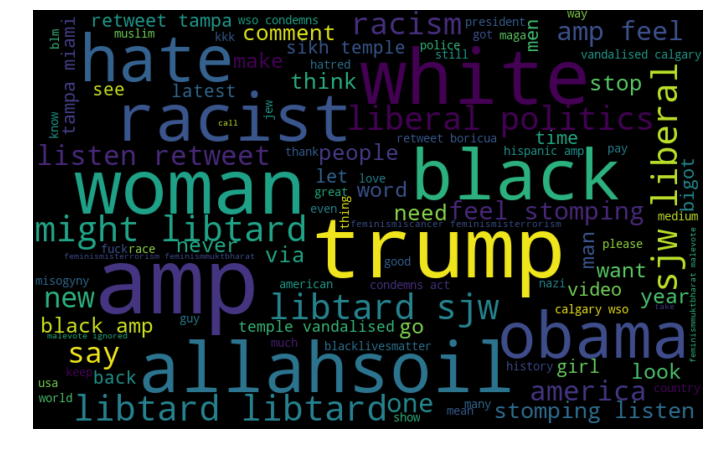

In [17]:
normal_words = ' '.join([word for word in df['clean_tweet'][df['label'] == 1]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

Normal words


(-0.5, 799.5, 499.5, -0.5)

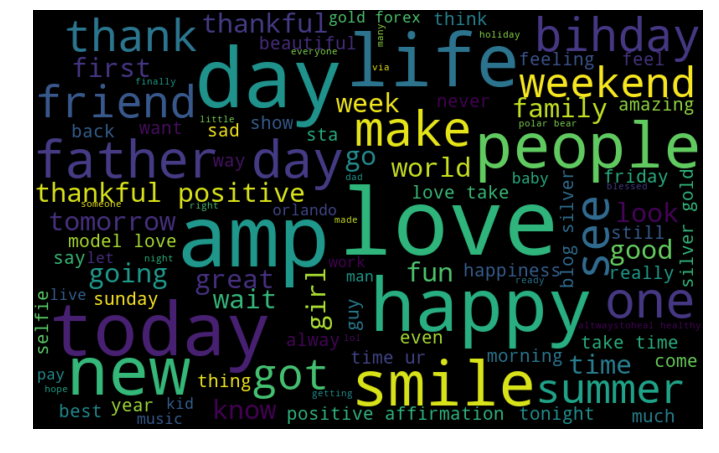

In [18]:
normal_words = ' '.join([word for word in df['clean_tweet'][df['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
print('Normal words')
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')

In [ ]:
# Checking the sentiment using TextBlob library
# TextBlob(text).sentiment returns two values- polarity and subjectivity
# After getting the values of both we'll convert them into series so that the values can be applied in 2 columns
# Polarity lies in [-1,1] --> +1 means very positive and -1 means very negative
df[['Polarity', 'Subjectivity']] = df['clean_tweet'].apply(lambda text: pd.Series(TextBlob(text).sentiment))

df[['clean_tweet','Polarity', 'Subjectivity']]

,clean_tweet,Polarity,Subjectivity
0,father dysfunctional selfish drag kid dysfunct...,-0.300000,0.535417
1,thanks lyft credit not use cause not offer whe...,0.200000,0.200000
2,bihday majesty,0.000000,0.000000
3,model love take time ur,0.500000,0.600000
4,factsguide society motivation,0.000000,0.000000
5,huge fan fare big talking leave chaos pay disp...,0.200000,0.500000
6,camping tomorrow danny,0.000000,0.000000
7,next school year year exam not think school ex...,-0.400000,0.450000
8,love land allin cavs champion cleveland clevel...,0.500000,0.600000
9,welcome gr,0.800000,0.900000


In [ ]:
for tweet in df['clean_tweet']:
    analyse = TextBlob(tweet, analyzer=NaiveBayesAnalyzer())
    pred= analyse.sentiment[0]

In [ ]:
pre= pd.Series(pred)

In [ ]:
pre= pre.replace({'pos':0, 'neg':0})

In [ ]:
test= pre[s:]

In [ ]:
df1= pd.concat([df_test['id'],test],axis=1)
df1.columns=['id','label']

In [ ]:
df1.to_csv("Twitter_hate_solution.csv", index= False)